# Time series Part 1: Point data tutorial

Waterhackweek 2020 Yifan Cheng (http://www.yifancheng.com/)

# Goal of this presentation:
At the end of this presentation, you will be able to:
* Get access to GIS shapefile of river basin boundaries and river networks
* Basic skills of plotting spatial maps
* Downloading precipitation and streamflow data using **ulmo**
* Conduct basic statistical analysis using **pandas**

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats

import ulmo

import matplotlib.pyplot as plt
import folium
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import geopandas as gpd

import warnings



Credit: this notebook was adapted from https://github.com/waterhackweek/tsdata_access (Emilio Mayorga, Yifan Cheng)

## Table of content
* 1. Study domain
 - 1.1. Download river basin boundary and river network data
 - 1.2. Interactive maps
* 2. Access Precipitation/Streamflow data using Ulmo
 - 2.1. Collect Precipitation sites information
 - 2.2. Download precipitation data from NCDC GHCN_daily
 - 2.3. Collect all streamflow sites information within this river basin
 - 2.4. Download USGS data
* 3. Site-specific data analysis
 - 3.1. Time Series Plot
 - 3.2. Data Selecting and Indexing
 - 3.3. Basic Statistics
 - 3.4. Data Aggregation (Groupby/Resample)

# 1. Study domain
## Yakima River Basin
HUC8 code: 17030001

## 1.1. Download river basin boundary and river network data
#### Download Shapefiles from USGS website
https://www.usgs.gov/core-science-systems/ngp/national-hydrography/access-national-hydrography-products

#### Download River networks
* NDF plus: very detailed river network (https://www.usgs.gov/core-science-systems/ngp/national-hydrography/access-national-hydrography-products)
* Geospatial Fabric: coarser resolution, designed for National Hydrologic Modeling (https://www.sciencebase.gov/catalog/item/535eda80e4b08e65d60fc834)

#### Then we use geopandas to plot the study domain



In [2]:
# selected huc region
HUC8code = '17030001'

In [11]:
# read in the shapefile
WBD_gdf = gpd.read_file('zip://data/basin_boundary_shp/WBDHU8.zip/WBDHU8.shp')

In [10]:
WBD_gdf

,objectid,tnmid,metasource,sourcedata,sourceorig,sourcefeat,loaddate,areasqkm,areaacres,referenceg,name,states,huc8,shape_Leng,shape_Area,geometry
0,1,{D26F1AB3-BA42-4B26-BEFB-2A055C6EF1D5},None,None,None,None,2020-03-09,2949.03,728720.19,None,Wilson-Trusk-Nestuccu,OR,17100203,3.721266,0.338841,"POLYGON ((-123.52985 45.68273, -123.52962 45.6..."
1,2,{08D11F90-08BB-4579-8BC6-6C8F5C92BBBC},None,None,None,None,2020-03-09,2270.87,561143.90,None,Siletz-Yaquina,OR,17100204,3.046481,0.258187,"POLYGON ((-123.95192 45.06779, -123.95167 45.0..."
2,3,{1F9A8978-7AF6-4B64-83A8-6296AF7194FD},None,None,None,None,2020-03-09,4849.49,1198333.82,None,Upper Willamette,OR,17090003,6.066603,0.547876,"POLYGON ((-123.38229 44.90266, -123.38196 44.9..."
3,4,{C19C3336-0531-43B8-8DAC-569C87D4E46C},None,None,None,None,2020-03-09,3468.30,857034.87,None,Mckenzie,OR,17090004,4.384080,0.390227,"POLYGON ((-122.02273 44.50785, -122.02237 44.5..."
4,5,{3DB62677-1E95-4C7F-A328-2DF39761B05D},None,None,None,None,2020-03-09,1841.40,455018.41,None,Middle Willamette,OR,17090007,5.290505,0.210340,"POLYGON ((-123.04359 45.38033, -123.04345 45.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,225,{74A3E042-4ABB-40FF-8CAE-FEEFF7744377},None,None,None,None,2020-06-14,2213.88,547061.34,None,Nehalem,OR,17100202,2.971419,0.256404,"POLYGON ((-123.36970 46.09480, -123.36921 46.0..."
225,226,{9D4DB191-DF7E-4F11-86ED-12180B663C8A},None,None,None,None,2020-06-14,1836.16,453723.66,None,Tualatin,OR,17090010,2.962794,0.211521,"POLYGON ((-123.07269 45.79252, -123.07234 45.7..."
226,227,{094A0FE0-A2A8-40B0-8D80-3B57F9F2BF36},None,None,None,None,2020-06-14,2964.72,732598.14,None,Lower Columbia-Clatskanie,"OR,WA",17080003,6.242611,0.344581,"POLYGON ((-123.21230 46.40174, -123.21214 46.4..."
227,228,{06AF8308-46D6-4475-9FFF-41A95B751196},None,None,None,None,2020-06-14,1756.25,433979.57,None,Lower Columbia,"OR,WA",17080006,2.972367,0.204716,"POLYGON ((-123.41680 46.49538, -123.41676 46.4..."


In [5]:
# select the corresponding basin based on huc8 code
domain_gdf = WBD_gdf[WBD_gdf['huc8']==HUC8code]
domain_gdf

,objectid,tnmid,metasource,sourcedata,sourceorig,sourcefeat,loaddate,areasqkm,areaacres,referenceg,name,states,huc8,shape_Leng,shape_Area,geometry
106,107,{A11BFB91-D397-4850-99A8-46D0F7C3333F},None,None,None,None,2017-11-06,5539.83,1368921.28,None,Upper Yakima,WA,17030001,4.967206,0.656349,"POLYGON ((-121.11502 47.59724, -121.11471 47.5..."


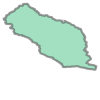

In [6]:
domain_geometry = domain_gdf.geometry[106]
domain_geometry

In [12]:
# read in river networks

gsf_gdf = gpd.read_file('zip://data/river_network_shp/nsegment_17.zip/nsegment_17.shp')


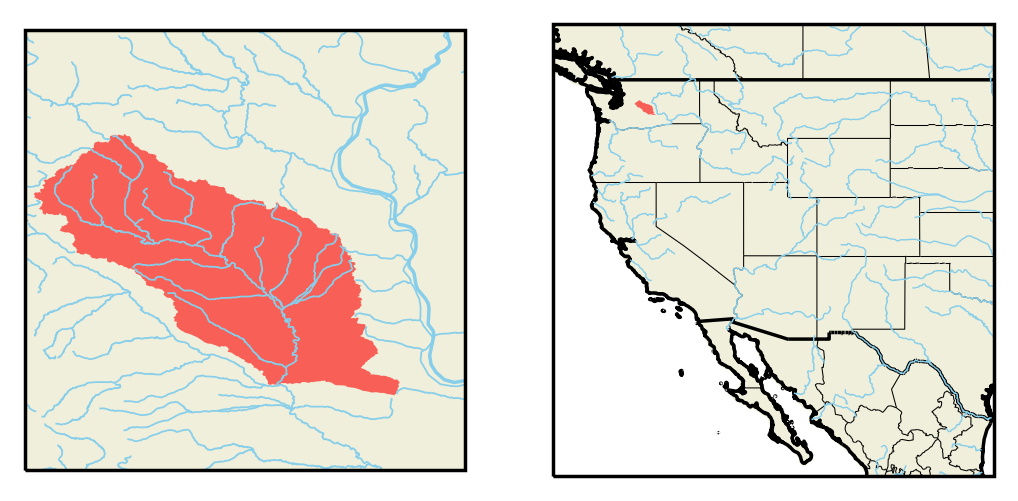

In [13]:
# ========================================= #
#            plot the spatial map           #
# ========================================= #


states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')

country_bound = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_0_boundary_lines_land',
                   scale='10m',
                   facecolor='none')

coastline = cfeature.NaturalEarthFeature(
                   category='physical',
                   name='coastline',
                   scale='10m',
                   facecolor='none')

river = cfeature.NaturalEarthFeature(
                   category='physical',
                   name='rivers_lake_centerlines',
                   scale='10m',
                   facecolor='none')

reservoir = cfeature.NaturalEarthFeature(
                   category='physical',
                   name='lakes',
                   scale='10m',
                   facecolor='none')

fig = plt.figure(figsize=(5,5),dpi=250)                # plot size and resolution

# ==============left map================= #
ax0 = plt.subplot(121, projection=ccrs.PlateCarree())  # set projection
ax0.set_extent([-121.5, -119.8, 46.3, 48.0])           # set boundary

# add state boundary, coast line, etc.
ax0.add_feature(states_provinces, edgecolor='sienna', 
                linewidth=0.5, zorder = 1)
ax0.add_feature(coastline, edgecolor='black', 
                zorder = 1)
ax0.add_feature(river,edgecolor='skyblue', zorder=1)
ax0.add_feature(country_bound, edgecolor='black', 
                zorder = 1)
ax0.add_feature(cfeature.LAND)

# plot study domain
domain_gdf.plot(ax=ax0,color='red', transform=ccrs.PlateCarree(), alpha=0.6)

# 1. plot GSF river network
gsf_gdf.plot(ax=ax0, color='skyblue', transform=ccrs.PlateCarree(), linewidth=0.5)

# ==============right map================= #
ax0 = plt.subplot(122, projection=ccrs.PlateCarree())  # set projection
ax0.set_extent([-127, -97, 22, 52])                    # set boundary

# add state boundary, coast line, etc.
ax0.add_feature(states_provinces, edgecolor='k', 
                linewidth=0.3, zorder = 1)
ax0.add_feature(coastline, edgecolor='black', 
                zorder = 1)
ax0.add_feature(river,edgecolor='skyblue', linewidth=0.4, zorder=1)
ax0.add_feature(country_bound, edgecolor='black', 
                zorder = 0.5)
ax0.add_feature(cfeature.LAND)

# plot study domain
domain_gdf.plot(ax=ax0, color='red',alpha=0.6)


## 1.2. Interactive maps

In [14]:
# find all coordinates of the shape file
all_coords = []
for b in domain_gdf.boundary: # for first feature/row
    coords = np.dstack(b.coords.xy).tolist()
    all_coords.append(*coords)   
    
# flip lon/lat to lat/lon
latlon=[]
for coords in all_coords[0]:
    latlon.append([coords[1],coords[0]])

In [68]:
# plot the interactive map

# the basemap is embedded within the folium package
m = folium.Map(tiles='Stamen terrain')

# plot the layer of our study domain
folium.vector_layers.Polygon(latlon, popup=['Upper Yakima'], fill_color='#2b8cbe').add_to(m)
    
# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

m

# Research questions:
# Is precipitation a good indicator to predict the streamflow?
## Methods:
* Interannual variability: Check whether annual precipitation is linearly correlated with mean annual streamflow?
* Seasonality: Check whether the precipitation seasonality is similar to flow seasonality?

# 2. Access Precipitation/Streamflow data using Ulmo

Currently, [ulmo](https://github.com/ulmo-dev/ulmo) supports the following datasets / services:

* California Department of Water Resources Historical Data
* Climate Prediction Center Weekly Drought
* CUAHSI WaterOneFlow
* Lower Colorado River Authority Hydromet and Water Quality Data
* NASA Daymet weather data
* National Climatic Data Center Climate Index Reference Sequential (CIRS)
* **National Climatic Data Center Global Historical Climate Network Daily**
* National Climatic Data Center Global Summary of the Day
* Texas Weather Connection Daily Keetch-Byram Drought Index (KBDI)
* US Army Corps of Engineers - Tulsa District Water Control
* **USGS National Water Information System (NWIS)**
* USGS Emergency Data Distribution Network services
* USGS Earth Resources Observation Systems (EROS) services
* USGS National Elevation Dataset (NED) services

Upper Yakima HUC8 code: 17030001 

## 2.1. Collect Precipitation sites information
https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt

In [16]:
# Collect sites information （find all sites in Washington State）

precip_site_df = ulmo.ncdc.ghcn_daily.get_stations(country='US',
                                                    state='WA',
                                                    elements='PRCP',
                                                    start_year=1980,
                                                    end_year=2020,
                                                    update=True,
                                                    as_dataframe=True)

In [17]:
precip_site_df

,country,network,network_id,latitude,longitude,elevation,state,name,gsn_flag,hcn_flag,wm_oid,id
id,,,,,,,,,,,,
US1WAAD0002,US,1,WAAD0002,46.7849,-119.1915,303.3,WA,OTHELLO 2.7 SSW,NaN,NaN,NaN,US1WAAD0002
US1WAAD0003,US,1,WAAD0003,46.8111,-119.1549,332.5,WA,OTHELLO 0.9 SE,NaN,NaN,NaN,US1WAAD0003
US1WAAD0004,US,1,WAAD0004,46.7838,-119.1912,302.1,WA,OTHELLO 2.8 SSW,NaN,NaN,NaN,US1WAAD0004
US1WAAD0005,US,1,WAAD0005,46.8321,-119.1562,341.4,WA,OTHELLO 1.0 NNE,NaN,NaN,NaN,US1WAAD0005
US1WAAD0006,US,1,WAAD0006,46.7611,-119.2181,259.7,WA,OTHELLO 4.8 SSW,NaN,NaN,NaN,US1WAAD0006
...,...,...,...,...,...,...,...,...,...,...,...,...
USW00094266,US,W,00094266,48.1203,-123.4983,87.8,WA,PORT ANGELES INTL AP,NaN,NaN,NaN,USW00094266
USW00094274,US,W,00094274,47.2675,-122.5761,89.0,WA,TACOMA NARROWS AP,NaN,NaN,NaN,USW00094274
USW00094276,US,W,00094276,48.5222,-123.0231,33.2,WA,FRIDAY HARBOR AP,NaN,NaN,NaN,USW00094276


In [18]:
# transfer pandas dataframe to a geopandas dataframe
precip_site_gdf = gpd.GeoDataFrame(precip_site_df, 
                                   geometry=gpd.points_from_xy(precip_site_df.longitude, precip_site_df.latitude))

In [19]:
precip_site_gdf

,country,network,network_id,latitude,longitude,elevation,state,name,gsn_flag,hcn_flag,wm_oid,id,geometry
id,,,,,,,,,,,,,
US1WAAD0002,US,1,WAAD0002,46.7849,-119.1915,303.3,WA,OTHELLO 2.7 SSW,NaN,NaN,NaN,US1WAAD0002,POINT (-119.19150 46.78490)
US1WAAD0003,US,1,WAAD0003,46.8111,-119.1549,332.5,WA,OTHELLO 0.9 SE,NaN,NaN,NaN,US1WAAD0003,POINT (-119.15490 46.81110)
US1WAAD0004,US,1,WAAD0004,46.7838,-119.1912,302.1,WA,OTHELLO 2.8 SSW,NaN,NaN,NaN,US1WAAD0004,POINT (-119.19120 46.78380)
US1WAAD0005,US,1,WAAD0005,46.8321,-119.1562,341.4,WA,OTHELLO 1.0 NNE,NaN,NaN,NaN,US1WAAD0005,POINT (-119.15620 46.83210)
US1WAAD0006,US,1,WAAD0006,46.7611,-119.2181,259.7,WA,OTHELLO 4.8 SSW,NaN,NaN,NaN,US1WAAD0006,POINT (-119.21810 46.76110)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
USW00094266,US,W,00094266,48.1203,-123.4983,87.8,WA,PORT ANGELES INTL AP,NaN,NaN,NaN,USW00094266,POINT (-123.49830 48.12030)
USW00094274,US,W,00094274,47.2675,-122.5761,89.0,WA,TACOMA NARROWS AP,NaN,NaN,NaN,USW00094274,POINT (-122.57610 47.26750)
USW00094276,US,W,00094276,48.5222,-123.0231,33.2,WA,FRIDAY HARBOR AP,NaN,NaN,NaN,USW00094276,POINT (-123.02310 48.52220)


In [20]:
# find sites within our study domain
precip_sel_site_gdf = precip_site_gdf[precip_site_gdf.within(domain_geometry)]

In [21]:
precip_sel_site_gdf

,country,network,network_id,latitude,longitude,elevation,state,name,gsn_flag,hcn_flag,wm_oid,id,geometry
id,,,,,,,,,,,,,
US1WAKT0001,US,1,WAKT0001,47.1560,-120.9297,729.1,WA,CLE ELUM 2.6 S,NaN,NaN,NaN,US1WAKT0001,POINT (-120.92970 47.15600)
US1WAKT0002,US,1,WAKT0002,46.9636,-120.4797,461.8,WA,ELLENSBURG 4.0 SE,NaN,NaN,NaN,US1WAKT0002,POINT (-120.47970 46.96360)
US1WAKT0008,US,1,WAKT0008,47.3915,-121.3939,808.9,WA,SNOQUALMIE PASS 2.6 SSE,NaN,NaN,NaN,US1WAKT0008,POINT (-121.39390 47.39150)
US1WAYK0003,US,1,WAYK0003,46.6964,-120.5822,472.1,WA,SELAH 3.6 NW,NaN,NaN,NaN,US1WAYK0003,POINT (-120.58220 46.69640)
US1WAYK0017,US,1,WAYK0017,46.6907,-120.4949,352.3,WA,SELAH 3.0 NE,NaN,NaN,NaN,US1WAYK0017,POINT (-120.49490 46.69070)
USC00451504,US,C,00451504,47.1889,-120.9131,579.1,WA,CLE ELUM,NaN,HCN,NaN,USC00451504,POINT (-120.91310 47.18890)
USC00452384,US,C,00452384,47.2422,-121.1869,661.4,WA,EASTON,NaN,NaN,NaN,USC00452384,POINT (-121.18690 47.24220)
USC00452505,US,C,00452505,46.9692,-120.5400,451.1,WA,ELLENSBURG,NaN,HCN,NaN,USC00452505,POINT (-120.54000 46.96920)
USC00452507,US,C,00452507,47.0294,-120.5386,519.7,WA,ELLENSBURG #2,NaN,NaN,NaN,USC00452507,POINT (-120.53860 47.02940)


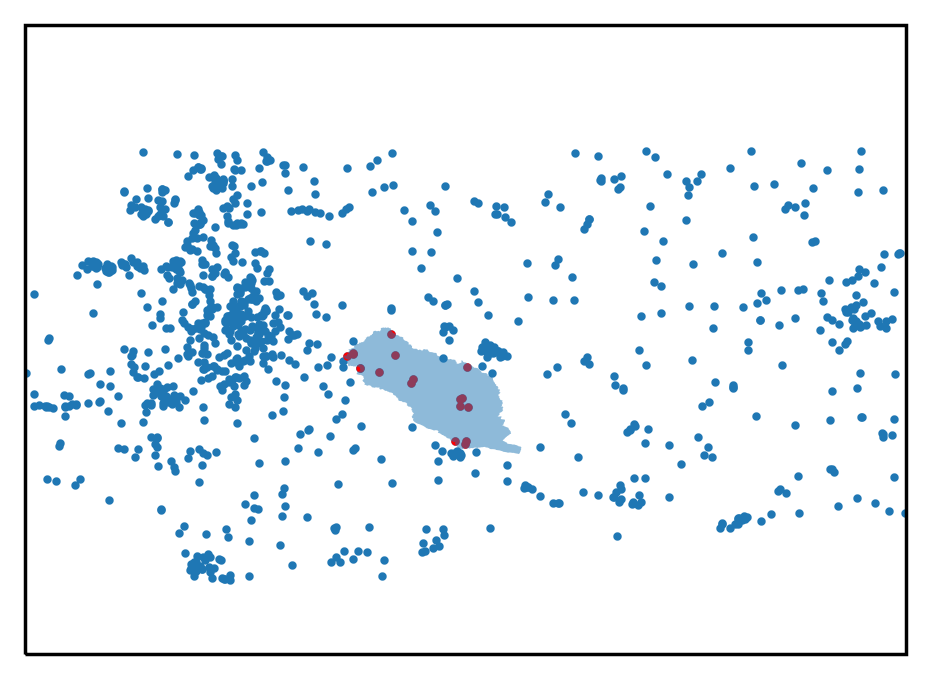

In [22]:
# check whether sites within our study domain has been properly selected

fig = plt.figure(figsize=(10,10),dpi=250)                # plot size and resolution

# ==============map================= #
ax0 = plt.subplot(121, projection=ccrs.PlateCarree())  # set projection
ax0.set_extent([-124, -117, 45, 50])                   # set extent

# sites in Washington State (blue)
precip_site_gdf.plot(ax=ax0, markersize=2)

# sites in our study domain (red)
precip_sel_site_gdf.plot(ax=ax0, color='red', markersize=2)

# study domain
domain_gdf.plot(ax=ax0, alpha=0.5)

In [71]:
# plot all selected sites using interactive maps

# plot base map
m = folium.Map(tiles='Stamen terrain')

# plot the layer of our study domain
folium.vector_layers.Polygon(latlon, popup=['Upper Yakima'], fill_color='#2b8cbe').add_to(m)

# plot all selected site locations
for idx, row in precip_sel_site_gdf.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], 
                  icon=folium.Icon(color='blue'),
                  popup="<b>Network: {0}</b>    Name: {1}      ID:{2}".format(
                      row['network'], row['name'], row['id'])
                 ).add_to(m)


# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

m

## 2.2. Download precipitation data from  NCDC GHCN_daily

In [24]:
# Selected upstream site in the mountains: USS0021B55S
# Selected downstream site in the dessert: USC00452505
precip_upstream = ulmo.ncdc.ghcn_daily.get_data(station_id='USS0021B55S',elements=['PRCP'],
                              as_dataframe=True)

precip_downstream = ulmo.ncdc.ghcn_daily.get_data(station_id='USC00452505',elements=['PRCP'],
                              as_dataframe=True)

/pool0/data/yifanc6/anaconda3/envs/whwtimeseries/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  axis=1)


In [25]:
precip_downstream

{'PRCP':              value mflag qflag sflag
 month_period                        
 1893-02-01      41   NaN   NaN     6
 1893-02-02      13   NaN   NaN     6
 1893-02-03      46   NaN   NaN     6
 1893-02-04       3   NaN   NaN     6
 1893-02-05       8   NaN   NaN     6
 ...            ...   ...   ...   ...
 2020-08-27       0   NaN   NaN     H
 2020-08-28       0   NaN   NaN     H
 2020-08-29     NaN   NaN   NaN   NaN
 2020-08-30     NaN   NaN   NaN   NaN
 2020-08-31     NaN   NaN   NaN   NaN
 
 [46598 rows x 4 columns]}

In [26]:
# change the index format
precip_upstream['PRCP'].index= precip_upstream['PRCP'].index.to_timestamp()

precip_downstream['PRCP'].index= precip_downstream['PRCP'].index.to_timestamp()

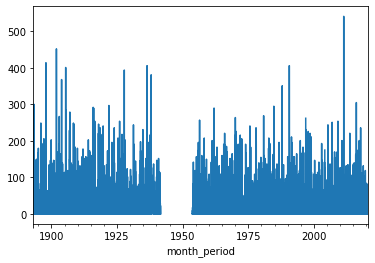

In [27]:
precip_downstream['PRCP']['value'].plot()

## 2.3. Collect all streamflow sites information within this river basin

In [28]:
nwis_sites = ulmo.usgs.nwis.get_sites(huc=HUC8code, service=None)

making request for sites: http://waterservices.usgs.gov/nwis/dv/
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&hucs=17030001
making request for sites: http://waterservices.usgs.gov/nwis/iv/
processing data from request: https://waterservices.usgs.gov/nwis/iv/?format=waterml&hucs=17030001


In [29]:
type(nwis_sites), len(nwis_sites)

(dict, 20)

In [30]:
nwis_sites.keys()

dict_keys(['12473980', '12473985', '12474500', '12475000', '12476000', '12477000', '12479000', '12479500', '12480000', '12480500', '12481000', '12481500', '12483500', '12483600', '12483800', '12484480', '12484500', '12485500', '12486500', '12487000'])

In [31]:
site_code = '12484500' #'12479500'

In [32]:
nwis_sites[site_code]

{'code': '12484500',
 'name': 'YAKIMA RIVER AT UMTANUM, WA',
 'network': 'NWIS',
 'agency': 'USGS',
 'location': {'latitude': '46.8626264',
  'longitude': '-120.480067',
  'srs': 'EPSG:4326'},
 'timezone_info': {'uses_dst': True,
  'dst_tz': {'abbreviation': 'PDT', 'offset': '-07:00'},
  'default_tz': {'abbreviation': 'PST', 'offset': '-08:00'}},
 'county': '53037',
 'huc': '17030001',
 'site_type': 'ST',
 'state_code': '53'}

In [33]:
# pull out lat & lon from the nested dictionary
for k, v in nwis_sites.items():
    v['longitude'] = v['location']['longitude']
    v['latitude'] = v['location']['latitude']

In [34]:
nwis_sites_df = pd.DataFrame(nwis_sites)
nwis_sites_df.head()

,12473980,12473985,12474500,12475000,12476000,12477000,12479000,12479500,12480000,12480500,12481000,12481500,12483500,12483600,12483800,12484480,12484500,12485500,12486500,12487000
code,12473980,12473985,12474500,12475000,12476000,12477000,12479000,12479500,12480000,12480500,12481000,12481500,12483500,12483600,12483800,12484480,12484500,12485500,12486500,12487000
name,"GOLD CREEK ABOVE KEECHELUS LAKE NEAR HYAK, WA","BOX CANYON CREEK NEAR HYAK, WA","YAKIMA RIVER NEAR MARTIN, WA","CABIN CREEK NEAR EASTON, WA","KACHESS RIVER NEAR EASTON, WA","YAKIMA RIVER AT EASTON, WA","CLE ELUM RIVER NEAR ROSLYN, WA","YAKIMA RIVER AT CLE ELUM, WA","TEANAWAY RIVER BELOW FORKS NEAR CLE ELUM, WA","TEANAWAY RIVER NEAR CLE ELUM, WA","SWAUK CREEK NEAR CLE ELUM, WA","CASCADE CANAL NEAR ELLENSBURG, WA","MANASTASH CREEK NEAR ELLENSBURG, WA","WILSON CREEK NEAR ELLENSBURG, WA","NANEUM CREEK NEAR ELLENSBURG, WA","CHERRY CREEK AT THRALL, WA","YAKIMA RIVER AT UMTANUM, WA","SELAH-MOXEE CANAL NEAR SELAH, WA","TAYLOR DITCH NEAR SELAH, WA","YAKIMA RIVER AT SELAH GAP NEAR NORTH YAKIMA, WA"
network,NWIS,NWIS,NWIS,NWIS,NWIS,NWIS,NWIS,NWIS,NWIS,NWIS,NWIS,NWIS,NWIS,NWIS,NWIS,NWIS,NWIS,NWIS,NWIS,NWIS
agency,USGS,USGS,USGS,USGS,USGS,USGS,USGS,USGS,USGS,USGS,USGS,USGS,USGS,USGS,USGS,USGS,USGS,USGS,USGS,USGS
location,"{'latitude': '47.3917792', 'longitude': '-121....","{'latitude': '47.35900289', 'longitude': '-121...","{'latitude': '47.32122417', 'longitude': '-121...","{'latitude': '47.2415036', 'longitude': '-121....","{'latitude': '47.2612262', 'longitude': '-121....","{'latitude': '47.2387267', 'longitude': '-121....","{'latitude': '47.24456209', 'longitude': '-121...","{'latitude': '47.19123078', 'longitude': '-120...","{'latitude': '47.2465092', 'longitude': '-120....","{'latitude': '47.19567717', 'longitude': '-120...","{'latitude': '47.1637336', 'longitude': '-120....","{'latitude': '47.1095676', 'longitude': '-120....","{'latitude': '46.96651326', 'longitude': '-120...","{'latitude': '47.1262365', 'longitude': '-120....","{'latitude': '47.1267922', 'longitude': '-120....","{'latitude': '46.9259594', 'longitude': '-120....","{'latitude': '46.8626264', 'longitude': '-120....","{'latitude': '46.6892934', 'longitude': '-120....","{'latitude': '46.6795711', 'longitude': '-120....","{'latitude': '46.63095987', 'longitude': '-120..."


In [35]:
# Let's flip (transpose) the dataframe, so each row is a site
nwis_sites_df = nwis_sites_df.T
nwis_sites_df.head(2)

,code,name,network,agency,location,timezone_info,county,huc,site_type,state_code,longitude,latitude
12473980,12473980,"GOLD CREEK ABOVE KEECHELUS LAKE NEAR HYAK, WA",NWIS,USGS,"{'latitude': '47.3917792', 'longitude': '-121....","{'uses_dst': True, 'dst_tz': {'abbreviation': ...",53037,17030001,ST,53,-121.381483,47.3917792
12473985,12473985,"BOX CANYON CREEK NEAR HYAK, WA",NWIS,USGS,"{'latitude': '47.35900289', 'longitude': '-121...","{'uses_dst': True, 'dst_tz': {'abbreviation': ...",53037,17030001,ST,53,-121.2456489,47.35900289


In [36]:
# Final cleanups, improvements
nwis_sites_df['latitude'] = nwis_sites_df['latitude'].astype(float)
nwis_sites_df['longitude'] = nwis_sites_df['longitude'].astype(float)
nwis_sites_df.drop(columns=['location', 'timezone_info'], inplace=True)
nwis_sites_df.head(2)

,code,name,network,agency,county,huc,site_type,state_code,longitude,latitude
12473980,12473980,"GOLD CREEK ABOVE KEECHELUS LAKE NEAR HYAK, WA",NWIS,USGS,53037,17030001,ST,53,-121.381483,47.391779
12473985,12473985,"BOX CANYON CREEK NEAR HYAK, WA",NWIS,USGS,53037,17030001,ST,53,-121.245649,47.359003


In [37]:
nwis_sites_df['site_type'].value_counts()

ST        17
ST-CA      2
ST-DCH     1
Name: site_type, dtype: int64

Site type codes are defined at http://help.waterdata.usgs.gov/site_tp_cd. For our purposes:

* ST: Stream
* ST-CA: Canel
* ST-DCH: Ditch

We could also have issued the nwis.get_sites query by passing a site_type value or list, like this:

nwis_sits = ulmo.usgs.nwis.get_sites(huc=HUC8code, site_type=['ST'], service=None)

In [72]:
# plot the interactive map with all streamflow sites
m = folium.Map(tiles='Stamen terrain')

# plot the layer of our study domain
folium.vector_layers.Polygon(latlon, popup=['Upper Yakima'], fill_color='#2b8cbe').add_to(m)

# plot the location of streamflow sites
for idx, row in nwis_sites_df.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], 
                  icon=folium.Icon(color='blue' if row['site_type'] == 'ST' else 'gray'),
                  popup="<b>{0}</b> {1}. Site type: {2}. {3}".format(
                      row['code'], row['name'], row['site_type'], row['network'])
                 ).add_to(m)
    
# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

m

## 2.4. Download USGS data

Use functions from ulmo: ulmo.usgs.nwis.get_site_data()
   * site_code: USGS site number (str)
   * parameter_code: Variable code (str) ([Link to all USGS parameter code](https://help.waterdata.usgs.gov/codes-and-parameters/parameters), [Link to USGS parameters commonly used in hydrology](https://help.waterdata.usgs.gov/parameter_cd?group_cd=PHY))
        * 00010: Temperature, water, degrees Celsius
        * 00011: Temperature, water, degrees Fahrenheit
        * 00060: Discharge, cubic feet per second
   * statistic_code: Statistic code (str) ([Link to all USGS statistic code](https://help.waterdata.usgs.gov/stat_code))
        * 00001: Maximum
        * 00002: Minimum
        * 00003: Mean

In [39]:
# download USGS data using ulmo
param_code = '00060'
stat_code  = '00003'
start_date = '1910-01-01'
end_date   = '2020-12-31'
site_data = ulmo.usgs.nwis.get_site_data(site_code=site_code,parameter_code=param_code, service='daily',
                                         statistic_code=stat_code, start=start_date,end=end_date,
                                         methods="all")

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=12484500&parameterCd=00060&statCd=00003&startDT=1910-01-01&endDT=2020-12-31


In [40]:
# convert data format to Pandas Dataframe

df = pd.DataFrame(site_data['00060'+':'+
                            '00003']['values'])         # create dataframe
df[site_code] = df['value'].astype(float)       # convert ['value'] to float
df['date'] = pd.to_datetime(df['datetime'])             # convert ['datetime'] format to date and add as a new column
df.set_index(['date'],inplace=True)                     # set date to be index
df = df.drop(['datetime','value','qualifiers'],axis=1)  # delete column ['datetime']

# 3. Site-specific data analysis

## Frequently used packages
* [NumPy](https://numpy.org/) (Deal with **Array**)
    * Fundamental package for scientific computing
    * All following packages depends on Numpy
* [Pandas](https://pandas.pydata.org/) (Deal with **DataFrame (2D)**)
* [SciPy](https://www.scipy.org/) 
    * Built on NumPy, and matplotlib
* [Scikit Learn](https://scikit-learn.org/stable/)
    * Built on NumPy, SciPy, and matplotlib
    * Simple and efficient tools for predictive data analysis
        * Claassification, Regression, Clustering...
* ...


## 3.1. Time series plot

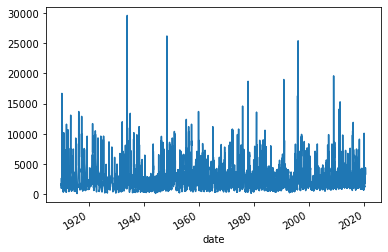

In [41]:
# quick check the time series
df[site_code].plot()

Text(0, 0.5, 'streamflow [ft$^3$/s]')

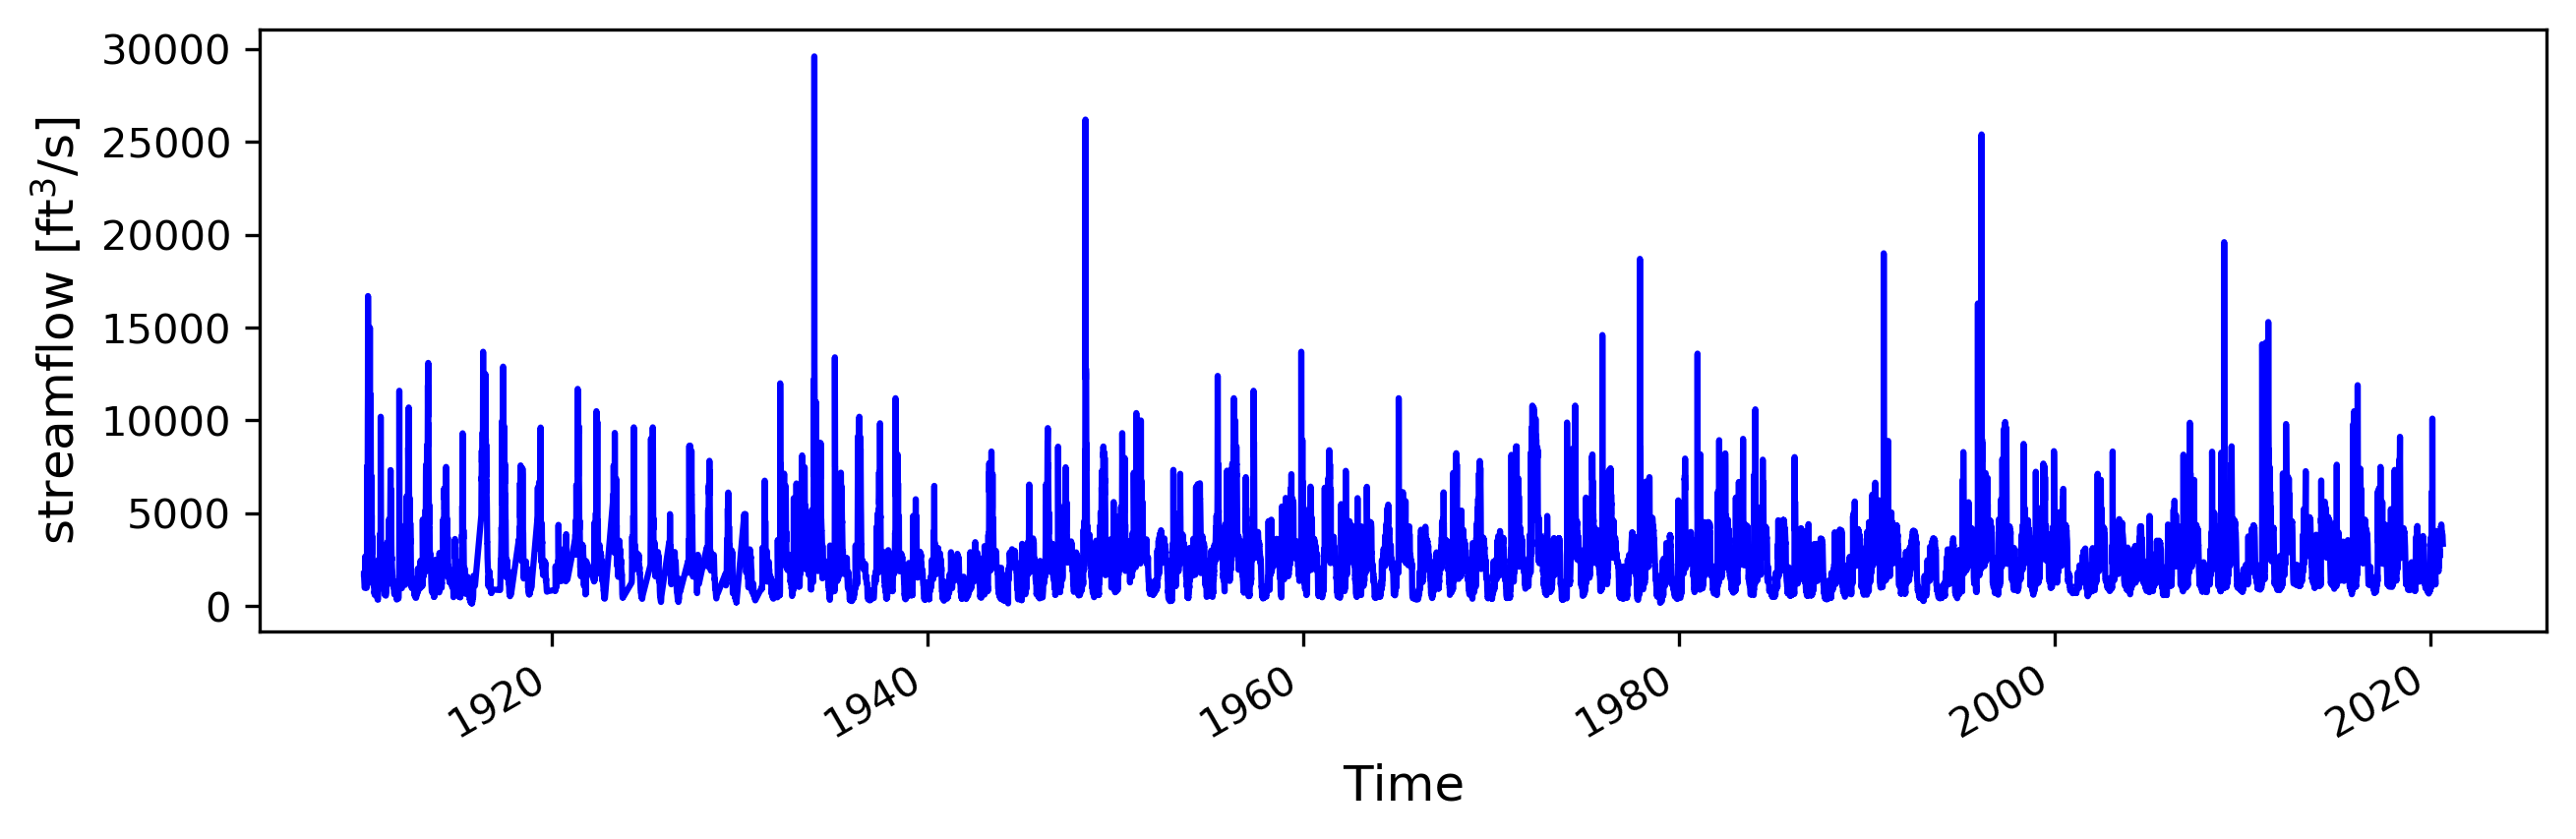

In [42]:
# a slightly more detailed plot
plt.figure(figsize=[10,3],dpi=300)

# time series plot 
df[site_code].plot(linestyle='-', color='b')

# add x-label and y-label
plt.xlabel("Time", fontsize=12)
plt.ylabel("streamflow [ft"+r"$^3$"+"/s]", fontsize=12)

## 3.2. Data Selecting and Indexing
* select column 
    * single column: df["col name"]
    * multiple columns: df[list of column names]
* select index (df.loc[index])
    * single index: df.loc[single date]
    * list of indexes: df.loc[date list]
    * slice of date: df.loc[slice(start date, end date)]

In [43]:
## select single column
df[site_code]

date
1910-01-01    1740.0
1910-01-02    1740.0
1910-01-03    1600.0
1910-01-04    1530.0
1910-01-05    1460.0
               ...  
2020-08-26    3590.0
2020-08-27    3520.0
2020-08-28    3460.0
2020-08-29    3400.0
2020-08-30    3360.0
Name: 12484500, Length: 38091, dtype: float64

In [44]:
## select single index
df.loc['1960-01-01']

12484500    5310.0
Name: 1960-01-01 00:00:00, dtype: float64

In [45]:
## select indexes
date_range=pd.date_range('1958-01-01','1960-01-31')
df.loc[date_range]

,12484500
1958-01-01,576.0
1958-01-02,592.0
1958-01-03,584.0
1958-01-04,592.0
1958-01-05,576.0
...,...
1960-01-27,1640.0
1960-01-28,1310.0
1960-01-29,1210.0
1960-01-30,1240.0


In [46]:
## select date range
df.loc[slice('1958-01-01','1960-01-31')]

,12484500
date,
1958-01-01,576.0
1958-01-02,592.0
1958-01-03,584.0
1958-01-04,592.0
1958-01-05,576.0
...,...
1960-01-27,1640.0
1960-01-28,1310.0
1960-01-29,1210.0


## 3.3. Basic Statistics
* Metrics:
    * Maximum, Minimum, Mean, Median, Standard Deviation. etc.
* Two ways to do it:
    * Transform to np.array and use Numpy to do it
    * Directly use Pandas
        * Along row or column:
            * metric in single column: axis = 0 (e.g., maximum temperature in each site)
            * metric in single row: axis = 1 (e.g., maximum temperature at a specific date)

In [47]:
# directly calculate the average
df.mean(axis=0)

12484500    2470.738705
dtype: float64

In [48]:
# A simple and quick way to get a summary of the metrics
df[site_code].describe()

count    38091.000000
mean      2470.738705
std       1789.960041
min        139.000000
25%       1150.000000
50%       2120.000000
75%       3310.000000
max      29600.000000
Name: 12484500, dtype: float64

## 3.4. Data Aggregation (Groupby/Resample)
* Resample versus Groupby
    * Resample: upscale the temporal resolution (frequency conversion), e.g., from daily to monthly
    * Groupby: split whole time series into different groups based on some metric. e.g., same month, same day of year etc., and then combine the results in the same group together
* Example
    * Calculate mean monthly temperature (**Resample**)
        * For each month in each year, calculate the mean stream temperature
    * Flow seasonality (**Groupby**)
        * Calculate mean flow for each month

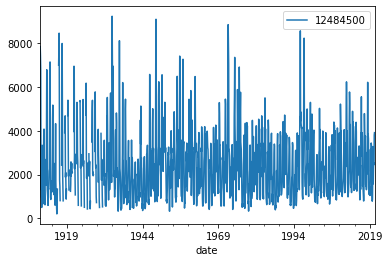

In [49]:
# calculate mean monthly streamflow
flow = df.resample('M').mean()
flow.plot()

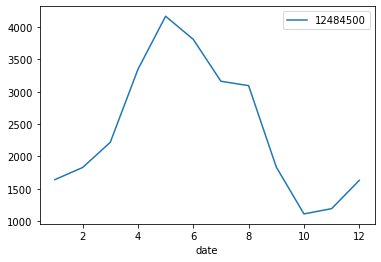

In [50]:
# calculate mean river flow in each month throughout all timeseries
df.groupby(df.index.month).mean().plot()

# Whether precipitation is a good indicator for streamflow?
* Interannual variability: Check whether annual precipitation is linearly correlated with mean annual streamflow?
* Seasonality: Check whether the precipitation seasonality is similar to flow seasonality?

## 1. Interannual variability

In [51]:
# quality control of the dataset

# calculate the total number of days with observations in each year
df_doy = precip_downstream['PRCP']['value'].resample('A').count()
df_tot_precip = (precip_downstream['PRCP']['value'].resample('A').sum()/10)
df_sum = pd.concat({'doy':df_doy,'tot_precip_down':df_tot_precip},axis=1)

# choose the years with days no fewer than 365 days
df_sum_quality_downstream = df_sum[df_sum['doy']>=365]



In [52]:
precip_downstream['PRCP']['value'].resample('A').sum()/10

month_period
1893-12-31    251.2
1894-12-31    198.4
1895-12-31    174.3
1896-12-31    285.2
1897-12-31    322.5
              ...  
2016-12-31    310.7
2017-12-31    306.2
2018-12-31    172.3
2019-12-31    218.7
2020-12-31     78.2
Freq: A-DEC, Name: value, Length: 128, dtype: float64

Text(0, 0.5, 'Annual precipitation [mm]\n@Downstream site')

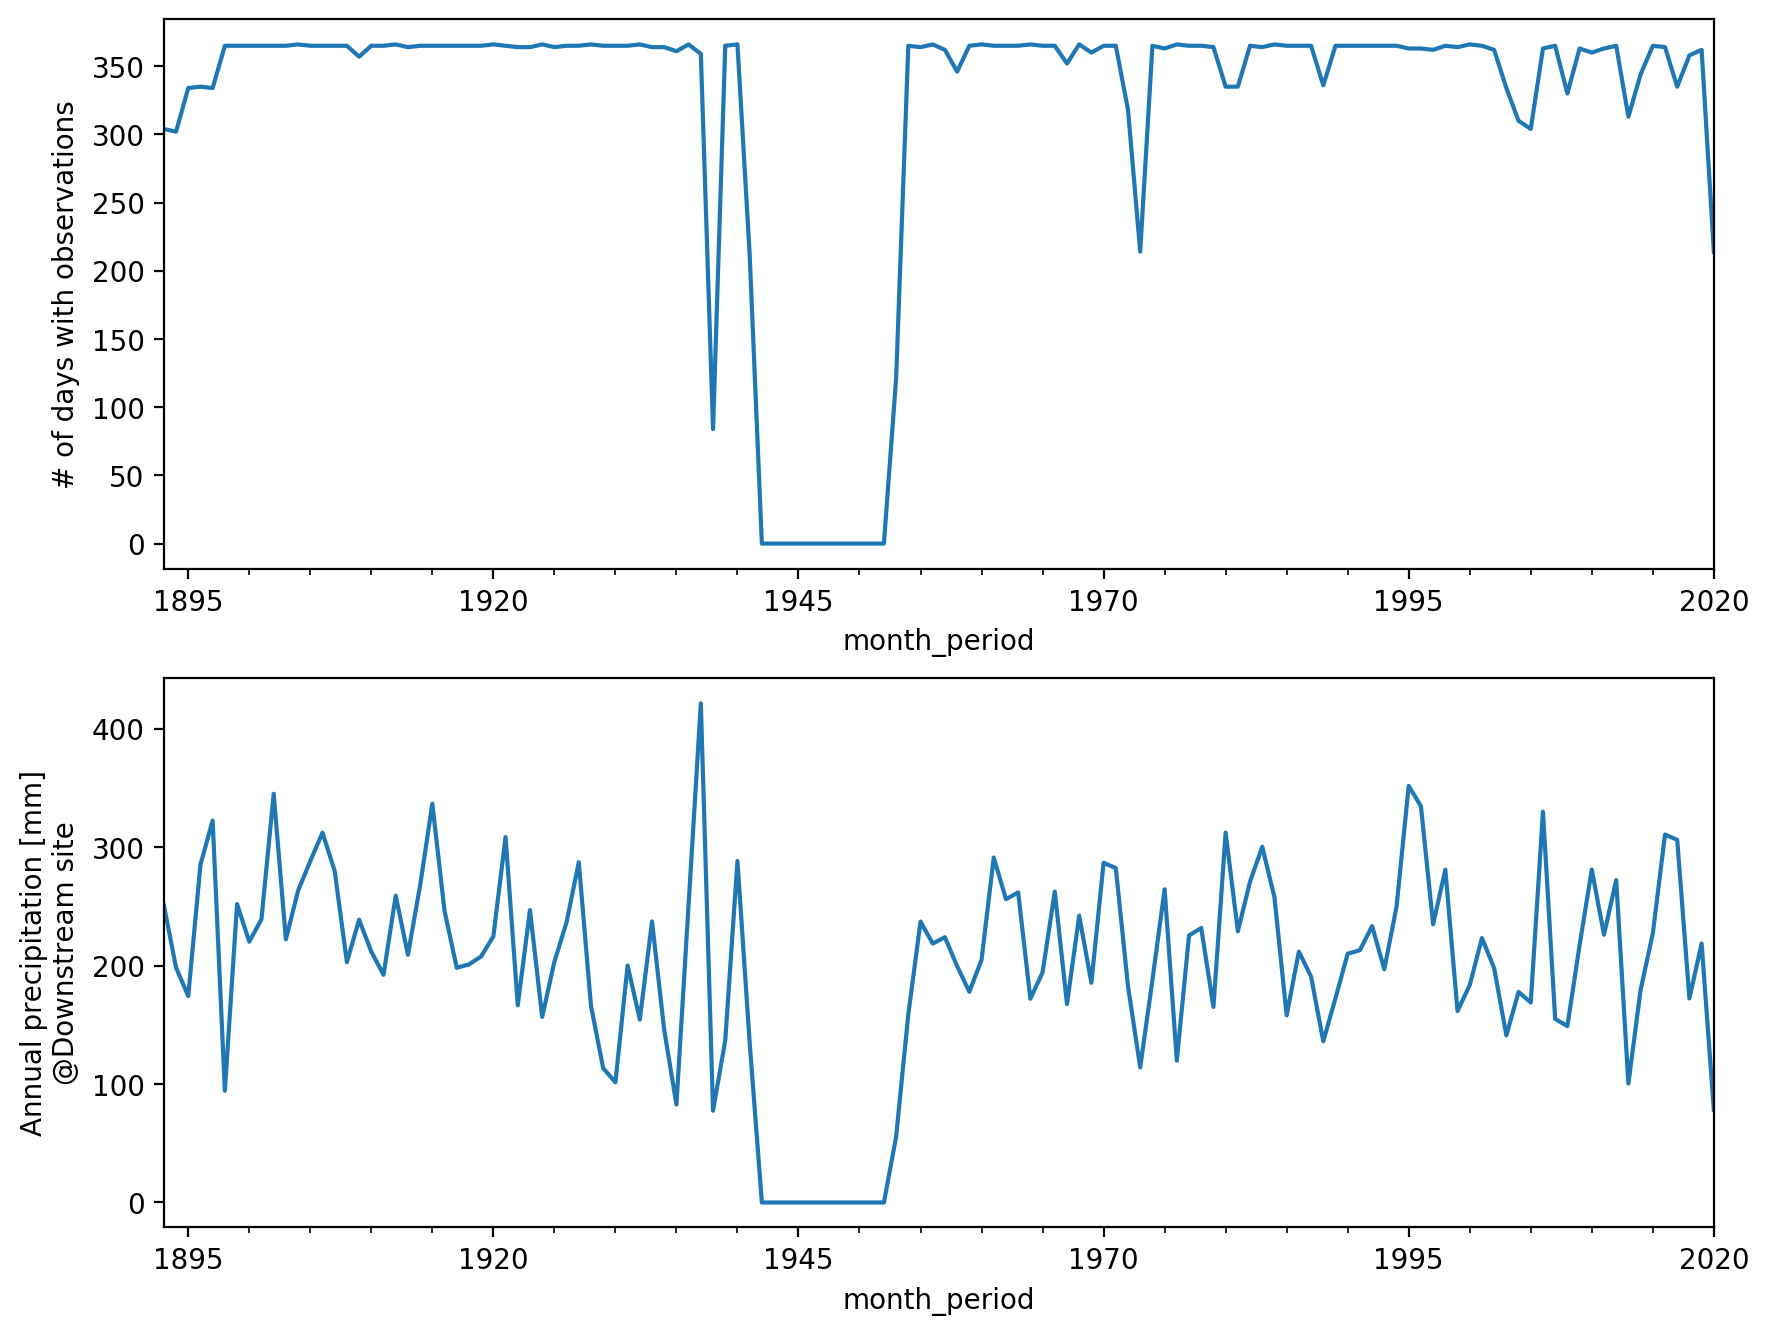

In [53]:
plt.figure(figsize=[10,8],dpi=200)
plt.subplot(211)
df_doy.plot()
plt.ylabel('# of days with observations')

plt.subplot(212)
df_tot_precip.plot()
plt.ylabel('Annual precipitation [mm]\n@Downstream site')

In [54]:
# do the same for downstream precipitation sites

# calculate the total number of days with observations in each year
df_doy = precip_upstream['PRCP']['value'].resample('A').count()
df_tot_precip = (precip_upstream['PRCP']['value'].resample('A').sum()/10)
df_sum = pd.concat({'doy':df_doy,'tot_precip_up':df_tot_precip},axis=1)

# choose the years with days no fewer than 365 days
df_sum_quality_upstream = df_sum[df_sum['doy']>=365]


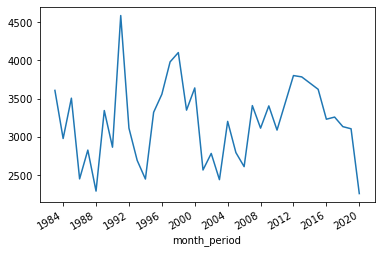

In [55]:
# quickly check annual precipitation time series
df_sum_quality_upstream['tot_precip_up'].plot()

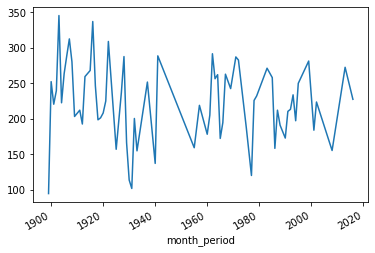

In [56]:
df_sum_quality_downstream['tot_precip_down'].plot()

In [57]:
# concatenate upstream and downstream time series together
df_sum = pd.concat([df_sum_quality_upstream,df_sum_quality_downstream],axis=1).dropna()

In [58]:
# calculate mean annual flow
df_annual_flow = df.resample('A').mean()
#df_annual_flow.index = pd.core.indexes.period.PeriodIndex(data=df_annual_flow.index.values, dtype='period[A-DEC]', name='month_period',freq='A-DEC')

# concat flow and precipitation data together and only select data when flow and precipitation are both available
df_final = pd.concat([df_annual_flow,df_sum],axis=1).dropna()

# Linear regression

In [59]:
# fit a linear regression between the streamflow and precipitation

slope_up, intercept_up, r_value_up, p_value_up, std_err_up = stats.linregress(df_final[site_code].values,df_final['tot_precip_up'].values)

slope_dn, intercept_dn, r_value_dn, p_value_dn, std_err_dn = stats.linregress(df_final[site_code].values,df_final['tot_precip_down'].values)


In [60]:
#slope_up, intercept_up, r_value_up, p_value_up, std_err_up

In [61]:
#slope_dn, intercept_dn, r_value_dn, p_value_dn, std_err_dn

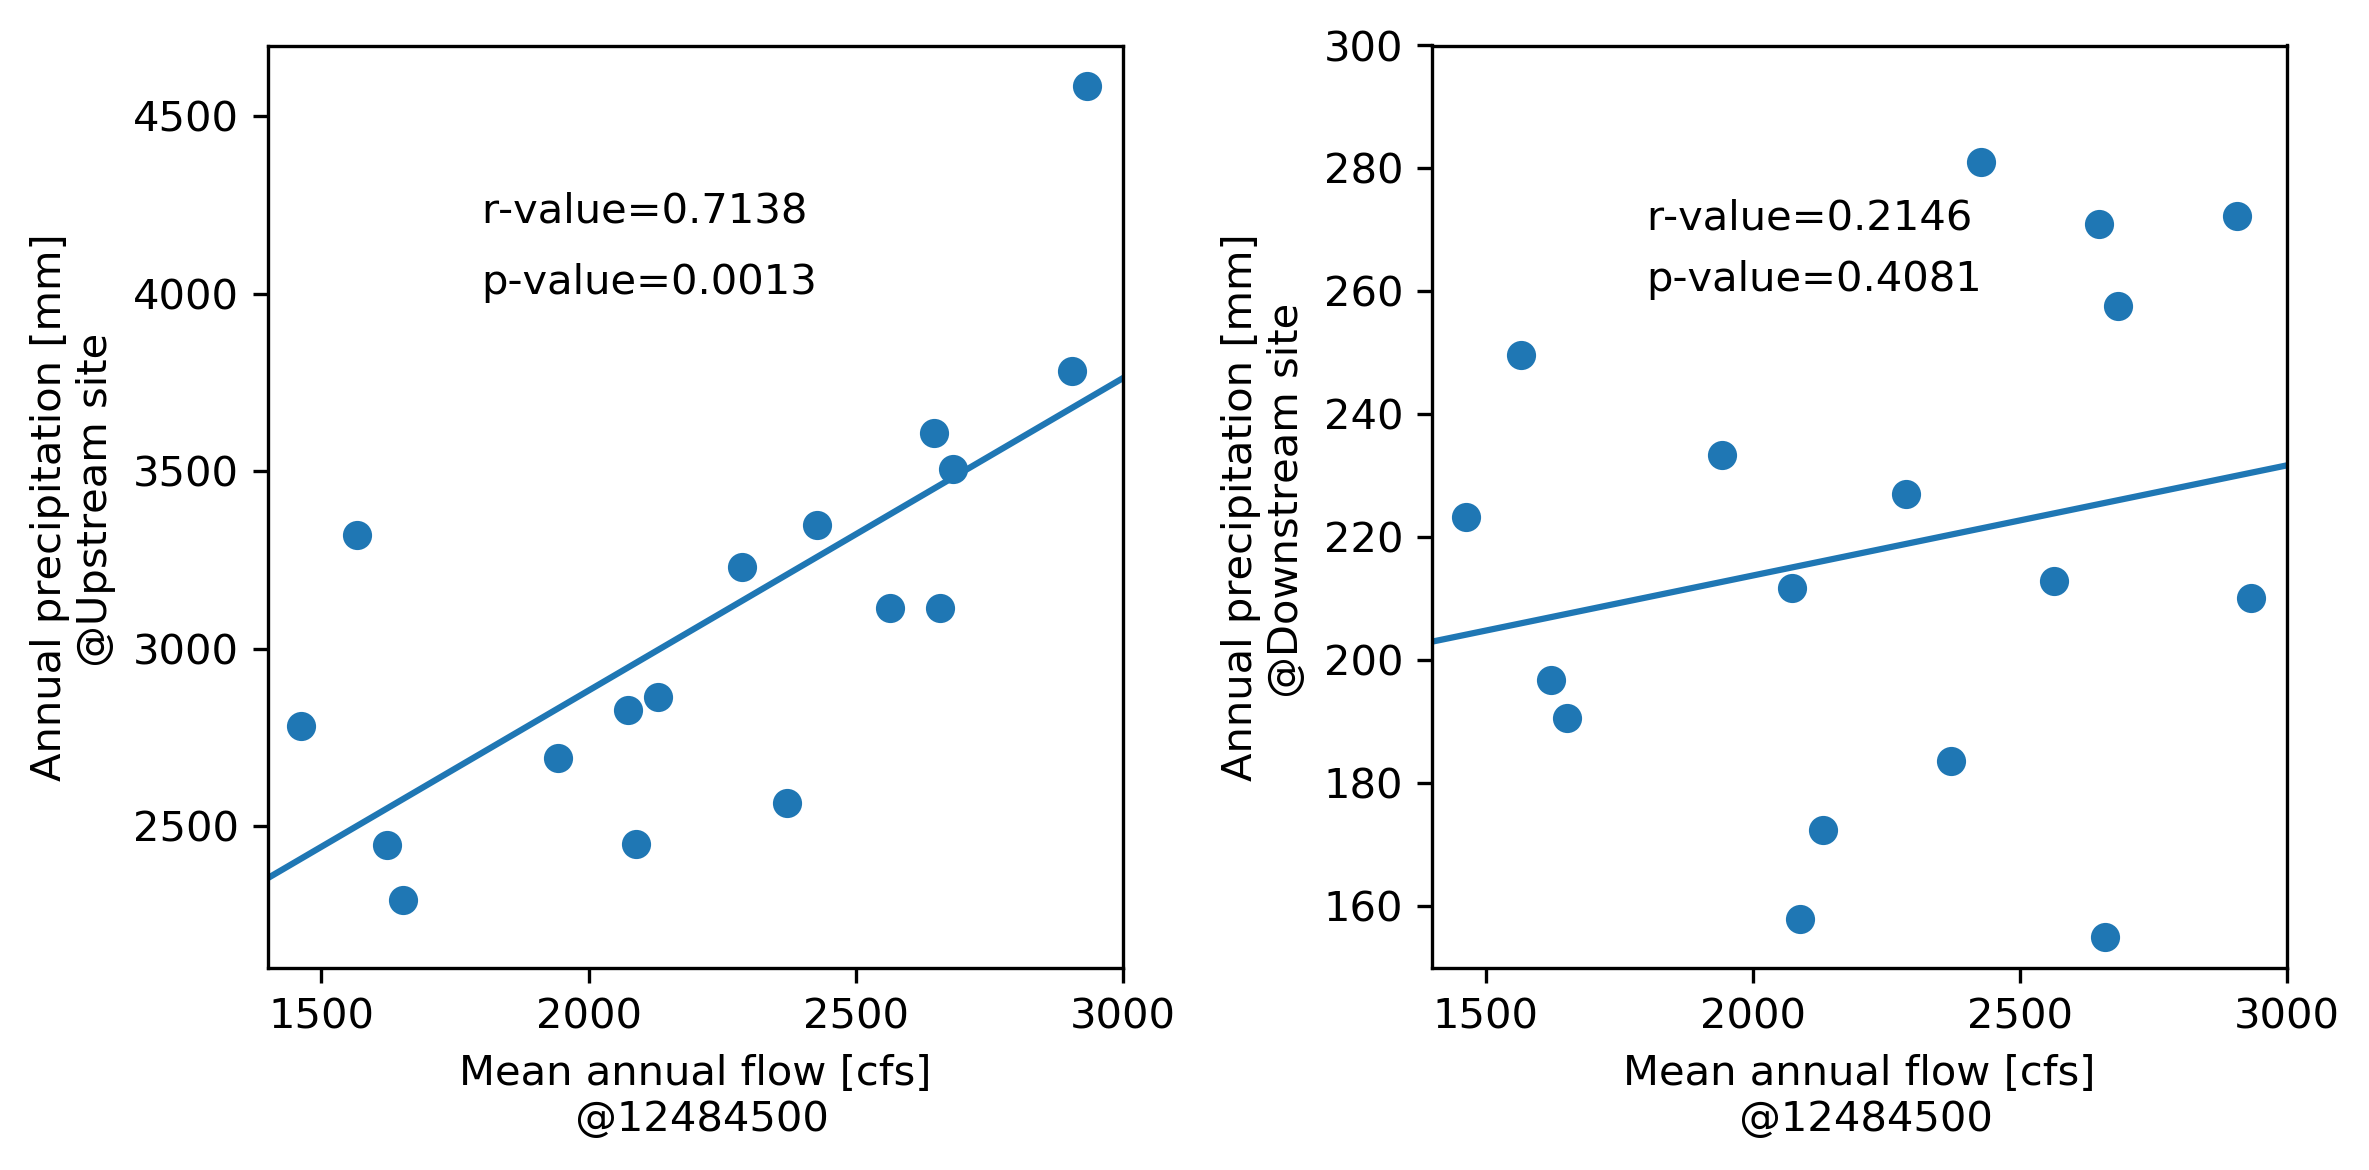

In [62]:
x_coords=np.array([0,4000])



plt.figure(figsize=[8,4],dpi=300)
plt.subplot(121)

# scatter plot of precipitation and streamflow 
plt.scatter(df_final[site_code],df_final['tot_precip_up'])

# plot the linear regression
plt.plot(x_coords, slope_up*x_coords+intercept_up)

# plot the x/y labels
plt.xlabel('Mean annual flow [cfs]\n @%s'%(site_code))
plt.ylabel('Annual precipitation [mm]\n @%s'%('Upstream site'))

# set the extent of the plot
plt.xlim([1400,3000])
plt.ylim([2100,4700])

# add r value and p value
plt.text(1800, 4000, "p-value=%s"%("%.4f"%(p_value_up)))
plt.text(1800, 4200, "r-value=%s"%("%.4f"%(r_value_up)))


plt.subplot(122)

# scatter plot of precipitation and streamflow 
plt.scatter(df_final[site_code],df_final['tot_precip_down'])


# plot the linear regression
plt.plot(x_coords, slope_dn*x_coords+intercept_dn)

# plot the x/y labels
plt.xlabel('Mean annual flow [cfs]\n @%s'%(site_code))
plt.ylabel('Annual precipitation [mm]\n @%s'%('Downstream site'))

# set the extent of the plot
plt.xlim([1400,3000])
plt.ylim([150,300])

# add r value and p value
plt.text(1800, 260, "p-value=%s"%("%.4f"%(p_value_dn)))
plt.text(1800, 270, "r-value=%s"%("%.4f"%(r_value_dn)))


plt.tight_layout()

# Upstream precipitation is a better indicator to predict streamflow!

## 2. Seasonality

In [63]:
# select a subperiod
precip_down_sub = precip_downstream['PRCP'].loc[slice("1984","1987")]
precip_up_sub = precip_upstream['PRCP'].loc[slice("1984","1987")]
df_flow_sub = df.loc[slice("1984","1987")]

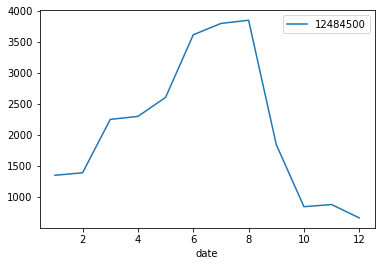

In [64]:
# calculate mean monthly flow
mean_month_flow = df_flow_sub.groupby(df_flow_sub.index.month).mean()
mean_month_flow.plot()

In [65]:
# calculate mean monthly precipitation

# first, use "resample" to calculate monthly precipitation
monthly_precip_down = precip_down_sub['value'].resample('M').sum()

# then use "groupby" to calculate mean monthly value
mean_month_precip_down = monthly_precip_down.groupby(monthly_precip_down.index.month).mean()

# first, use "resample" to calculate monthly precipitation
monthly_precip_up = precip_up_sub['value'].resample('M').sum()

# then use "groupby" to calculate mean monthly value
mean_month_precip_up = monthly_precip_up.groupby(monthly_precip_up.index.month).mean()

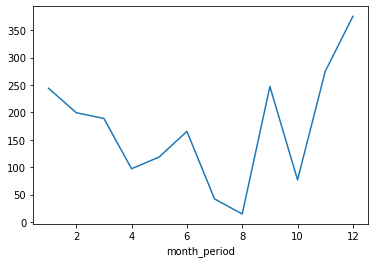

In [66]:
mean_month_precip_down.plot()

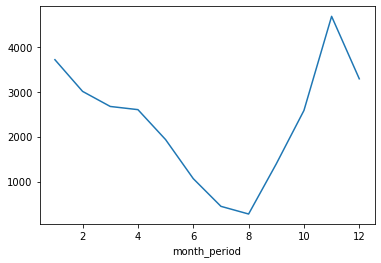

In [67]:
mean_month_precip_up.plot()

# Precipitation seasonality is not a good predictor for streamflow seasonality.